In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time
from cycler import cycler

In [2]:
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [3]:
# Compute the Mean Average Distance of inputs
def batched_MAD(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1).abs()
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

# Compute the Global Feature Similarity
def batched_GFS(X,edge_index,edge_weights,batch):
    X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
    
    GFS = 0
    for idx,batch_idx in enumerate(batch.unique()):
        cosine = torch.clip(1 - torch.matmul(X[batch==batch_idx].T,X[batch==batch_idx]).abs(),0,1)
        GFS += cosine.sum()/(cosine.shape[0]*(cosine.shape[0]-1))
    
    return GFS/(idx+1)

# Compute normalized (absolute) rayleigh quotient
def rayleigh_quotient(X,edge_index,edge_weights,batch,eig_max,eig_min):
    num = torch_scatter.scatter_sum(X * torch_scatter.scatter_sum(edge_weights[:,None] * 
                                        X[edge_index[1]], edge_index[0],dim=0),
                                        batch, dim=0)
    denom = torch_scatter.scatter_sum(X**2,batch,dim=0)
    R = num/(denom)
    return torch.mean((eig_max[:,None] - R.abs())/(eig_max - eig_min)[:,None])

# Katz Centrality

## Introduction & Experiments

Moving on from $d_{degree}$, we now analyze the ability of GCNs to learn Katz Centrality. The Katz Centrality of matrix $A\in{}R^{n\times{}n}$ is defined as

$$\vec{d}_{Katz} = \sum_{k=1}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} + \vec{\beta{}}$$

where necesarily $0\leq{}\alpha{}<\frac{1}{\lambda_{1}}$ [13]. Let $\lambda_{i}$ be the eigenvalues of $A$ such that $\lambda_{1}\geq{}\lambda_{2}\geq{}...\geq{}\lambda_{n}$. If $\alpha\neq{}\frac{1}{\lambda_{i}}$, the above expression is equivalent to $(I - \alpha{}A^{T})^{-1}\vec{1} - (\vec{1} - \vec{\beta{}})$, which we show below.

$$\sum_{k=1}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} + \vec{\beta{}} = (I - \alpha{}A^{T})^{-1}\vec{1} - (\vec{1} - \vec{\beta{}})$$
$$\sum_{k=1}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} + \vec{1} = (I - \alpha{}A^{T})^{-1}\vec{1}$$
$$(I - \alpha{}A^{T}) (\vec{1} + \sum_{k=1}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1}) = \vec{1}$$
$$(I - \alpha{}A^{T})\vec{1} + \sum_{k=1}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} - \sum_{k=2}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} = \vec{1}$$
$$ \vec{1} - \alpha{}A^{T}\vec{1} + \alpha{}A^{T}\vec{1} = \vec{1}$$
$$\vec{1} = \vec{1}$$

Katz Centrality is best understood as a hybridization of Degree Centrality (for small $\alpha{}$) and of Eigenvector Centrality (for large $\alpha$). 

$$\vec{d}_{eig} = \lim_{k\rightarrow{}\infty}(\frac{1}{|\lambda_{1}|}A^{T})^{k}\vec{1}$$

As a consequence of Perron-Frobenius theorem, Eigenvector Centrality is only well-defined for strongly connected networks. Katz Centrality addresses this via constant $\vec{\beta{}}$ and attenuation factor $\alpha{}$. If the network is strongly connected, then the two are equivalent under certain conditions, namely:

$$\lim_{\alpha{}\rightarrow{}\frac{1}{|\lambda_{1}|}}\vec{d}_{Katz} = \sum_{k=1}^{\infty}(\frac{1}{|\lambda_{1}|}A^{T})^{k}\vec{1} + \vec{\beta}$$
$$=\vec{\beta} + c_{1}\vec{v_{1}}(1+1+...) + c_{2}\vec{v_{2}}(\frac{\lambda_{2}}{|\lambda_{1}|} + (\frac{\lambda_{2}}{|\lambda_{1}|})^{2} + ...) + ...$$

since $\lambda_{1}>0$. $\frac{|\lambda_{2}|}{|\lambda_{1}|}<1$, so the second term dominates in the infinite sum if $\vec{\beta}$ is suitably small: 

$$\approx{} c\vec{v_{1}} = c\lim_{k\rightarrow{}\infty}(\frac{1}{|\lambda_{1}|}A^{T})^{k}\vec{1} $$

Constant $c$ vanishes anyway in the normalization. Choice of $\alpha{}<\frac{1}{|\lambda_{1}|}$ ensures convergence. For our purposes, $\alpha = \frac{1}{1.01|\lambda_{1}|}$ and $\vec{\beta{}}=\vec{0}$.

In [4]:
num_graphs = 250
d = []

torch.manual_seed(0)
for _ in range(num_graphs):
    n = torch.randint(50,100,(5,))
    p = 1/n + (10/n - 1/n) * torch.rand((5,5))
    p = .5 * (p + p.T)
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

To establish a basis for comparison, we first compute $\vec{d}_{Katz}$ via truncated sums as

$$\vec{d}_{Katz} = \sum_{k=1}^{q}(\alpha{}A^{T})^{k}\vec{1}$$

for all $q=1,2,3,...,64$ and plot the approximation error on our test set.

In [5]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    _,vecs = torch.eig(adj.to_dense(),eigenvectors=True)

    G.y = y
    d[idx] = G
    
train,test = d[:200],d[200::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=25,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=25,shuffle=True)

In [6]:
def KatzIterations(X,Y,edge_index,k=1024):
    Z = torch.zeros((k+1,X.shape[0])).cuda()
    output = torch.zeros((2,k+1)).cuda()
    adj = torch_sparse.SparseTensor(row=edge_index[0],col=edge_index[1]).cuda()
    
    alpha = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max()).cuda()

    Z[0] = X.squeeze()
    for i in range(k):
        X = alpha * torch_sparse.matmul(adj,X)
        if i==0: Z[i+1] = X.squeeze()
        else: Z[i+1] = Z[i] + X.squeeze()
        
    for i in range(k,-1,-1):
        output[0,i] = scaled_MAE(Y,Z[i],torch.zeros(X.shape[0]).cuda().long())
        output[1,i] = rank_disp(Y,Z[i],torch.zeros(X.shape[0]).cuda().long())
    return output

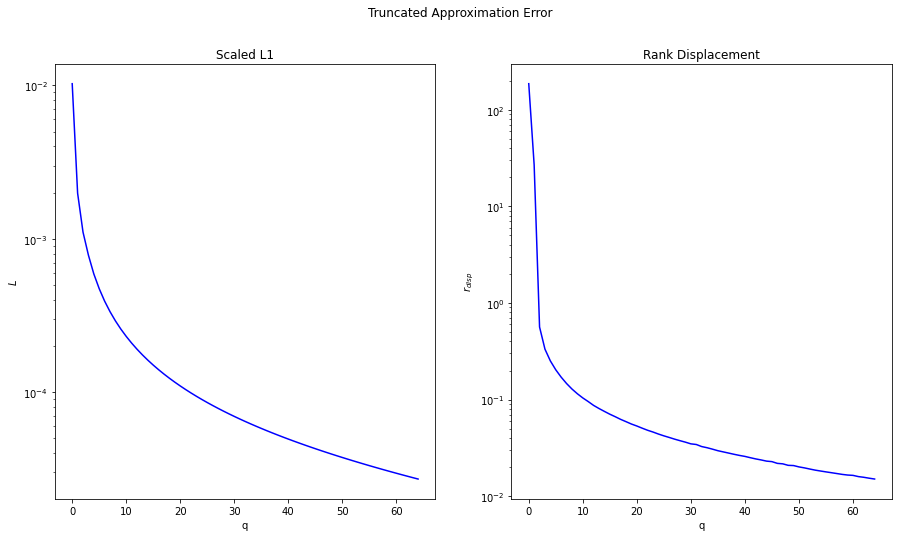

In [7]:
for idx,data in enumerate(test):
    if idx==0:
        error = KatzIterations(data.x.cuda(),data.y.cuda(),data.edge_index,64)
        torch.cuda.empty_cache()
    else:
        error += KatzIterations(data.x.cuda(),data.y.cuda(),data.edge_index,64)
error/=(idx+1)

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.semilogy(error[0].cpu(),color='blue')
plt.ylabel('$L$')
plt.xlabel('q');
plt.title('Scaled L1')

plt.subplot(1,2,2)
plt.semilogy(error[1].cpu(),color='blue')
plt.ylabel('$r_{disp}$')
plt.xlabel('q');
plt.title('Rank Displacement')

plt.suptitle('Truncated Approximation Error');

We see that it takes $q\approx{}4$ to obtain an $L$ of $1e^{-3}$ and an $r_{disp}$ of $3e^{-1}$. The main loop requires a total of $q|E| + (2q - 1)|V| $ operations. $\alpha{}$ can be suitably determined by $d$ successive Lanczos Iterations at a cost of $d(|E| + 3|V|-1) + 4(d-1)|V|$.

Below, we train GraphConv and EdgeConv to minimize $L(\vec{x},\vec{d}_{Katz})$ using the same proceedure as in Section 1. For constant intermediate dimension $R^{m}$ (the width of the model, so to speak), they require approx. $l_{max}(|E|m + |V|(m^{2} + 2m))$ and $l_{max}(|E|m^{2} + 2|V|m)$ operations. We set $l_{max}=4$ and experiment with $m=4,16$.

If $L$ is worse than that for the closest truncated sum in terms of operation count, then our GCNs will have little pratical value as approximators, as it would be more efficient to just manually compute $\vec{d}_{Katz}$. However, we are not so much interested in practicality as we are whether GCNs can even mimic Katz Centrality to a reasonable degree in the first place.

In [10]:
torch.manual_seed(0)

Graph4 = GraphConv(1,4,1,4).cuda()
Edge4 = EdgeConv(1,4,1,4).cuda()

graph4_metrics = train_loop(Graph4,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()
edge4_metrics = train_loop(Edge4,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()

Graph16 = GraphConv(1,16,1,4).cuda()
Edge16 = EdgeConv(1,16,1,4).cuda()

graph16_metrics = train_loop(Graph16,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()
edge16_metrics = train_loop(Edge16,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()

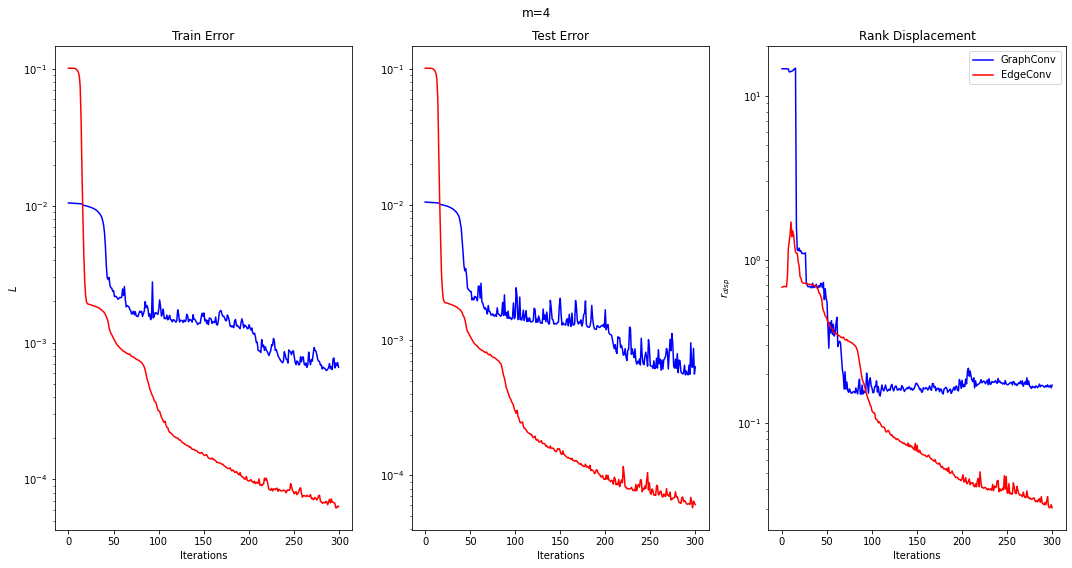

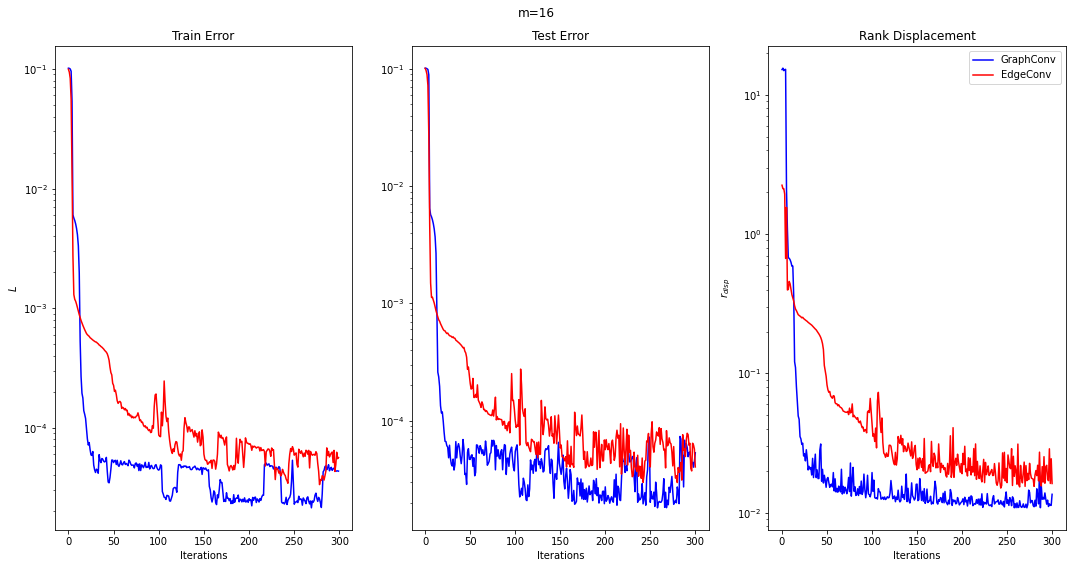

In [11]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph4_metrics[0],color='blue')
plt.semilogy(edge4_metrics[0],color='red')
plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph4_metrics[1],color='blue')
plt.semilogy(edge4_metrics[1],color='red')
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph4_metrics[2],color='blue',label='GraphConv')
plt.semilogy(edge4_metrics[2],color='red',label='EdgeConv')
plt.title('Rank Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend()
plt.suptitle("m=4")

plt.tight_layout();
plt.show()

plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph16_metrics[0],color='blue')
plt.semilogy(edge16_metrics[0],color='red')
plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph16_metrics[1],color='blue')
plt.semilogy(edge16_metrics[1],color='red')
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph16_metrics[2],color='blue',label='GraphConv')
plt.semilogy(edge16_metrics[2],color='red',label='EdgeConv')
plt.title('Rank Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend()
plt.suptitle("m=16")

plt.tight_layout();


We plot a) training loss b) test loss and c) average rank displacement. GraphConv converges to around $7e^{-4}$ for $m=4$ and $3e^{-5}$ for $m=16$; looking purely at the number of aggregations (i.e $l_{max}$ versues $q$), they each either meet or surpass the corresponding truncated sum approximation. Oddly enough, the $r_{disp}$ is much improved in the latter case, hovering at nearly $1e^{-2}$. Operation counts are in line with $q\approx{}20$ and $q\approx{}100$, so how useful these models are really will depend on the number of Lanczos iterations used to approximate $\alpha{}$ (and, even then, they'd need to be pretty high). Still, this all indicates to us that, if beneficial, GraphConv could implicitly learn a decent approximation to $\vec{d}_{Katz}$ as part of a downstream task.

We find the performance of EdgeConv to be mostly independent of $m$. If $m$ is small, then it already does pretty well (and noticably better than GraphConv), and the loss only marginally improves for large $m$. In general, EdgeConv requires nearly twice the runtime, so it may often be more practical to simply train a wider GraphConv model.

## But What About Low-Density Networks?

Our models have thus far only seen high-density SBMs wherein the ratio of leading eigenvalues is relatively small. As established, this ratio controls how close $A^{k}\vec{x}$ is to $\vec{v_{1}}$. At its most basic, graph convolution is simply succesive powers of the adjancency matrix seperated by a differentiable $\Theta$:

$$X^{l+1} = \Theta^{l}(A\Theta^{l-1}(A\Theta^{l-2}(...(\Theta^{1}(AX^{0})))$$

where $X\in{}R^{|V|\times{}n}$ is the network feature matrix. If all $\Theta$ are linear, then this can be considered a weighted form of the Power Iteration method i.e:

$$X^{l+1} = AX^{l}\Theta^{l}$$

or equivalently

$$X^{l+1} = A^{l}X^{0}\Theta^{l}$$

In the limit, $A^{l}X^{0}$ approaches the matrix $V$, where each column $V_{:i}$ is a copy of $\vec{v_{1}}$.

$$\lim_{l\rightarrow{}\infty{}} X^{l+1} = V\Theta^{l}$$

However, if $\frac{|\lambda_{2}|}{|\lambda_{1}|}\approx{}1$, then convergence to $V$ will be quite slow and require a large number of aggregations. 

Although this is a highly simplified model, it serves as a good motivating example. We are interested as to the extent which the spectral properties of a network impact our ability to learn its structure; after all, when the eigenvalue ratio is near maximum, the summand in $\vec{d}_{Katz}$, $(\alpha{}A)^{k}\vec{1}$,  requires $n>>0$ before converging to $\vec{v_{1}}$,

$$\vec{d}_{Katz} = \vec{\beta} + \sum_{k=1}^{n} (\alpha{}A)^{k}\vec{1} + \vec{v_{1}}\sum_{k=n+1}^{\infty}\alpha{}^{k}$$

at which point the second term can be computed without further powers of $A$. We can view the above equation as a series of linear graph convolutions followed by an MLP regression head. In this sense, it is likely that shallow GCNs are insufficient for learning the Katz Centrality of low-density, high eigenvalue-ratio SBMs. To test this, we generate a new dataset by decreasing the intra and inter-cluster probabilities, which leads to a lower graph density and greater $\frac{|\lambda_{2}|}{|\lambda_{1}|}$, and then train our $l_{max}=4,m=4,16$ models from scratch on the new data. These networks are increasingly likely to be disconnected, hence the need for Katz Centrality (as $\vec{d}_{eig}$ is not well-defined in that case).

We sample intra and inter-cluster probabilities from $p\in{}[\frac{1}{50n},\frac{1}{n}]$, which gives an average density of $.008$ with $E[\frac{|\lambda_{2}|}{|\lambda_{1}|}]\approx{}.925$ (so more than doubling the eigenvalue ratio). Like before, we also manually compute $\vec{d}_{Katz}$ for $q=1,2,3,...,64$ and plot the approximation error.

In [13]:
num_graphs = 250
d = []

torch.manual_seed(0)
for _ in range(num_graphs):
    
    # Set Cluster sizes and connection probabilties: [1/50n,1/n]
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

In [14]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
   # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    _,vecs = torch.eig(adj.to_dense(),eigenvectors=True)
    
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    
train,test = d[:200],d[200::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=25,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=25,shuffle=True)

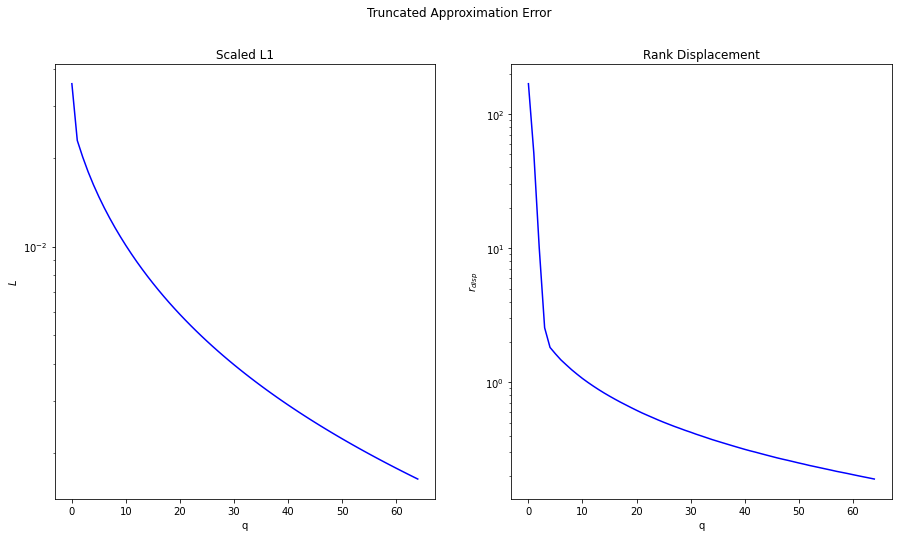

In [15]:
for idx,data in enumerate(test):
    if idx==0:
        error = KatzIterations(data.x.cuda(),data.y.cuda(),data.edge_index,64)
        torch.cuda.empty_cache()
    else:
        error += KatzIterations(data.x.cuda(),data.y.cuda(),data.edge_index,64)
error/=(idx+1)

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.semilogy(error[0].cpu(),color='blue')
plt.ylabel('$L$')
plt.xlabel('q');
plt.title('Scaled L1')

plt.subplot(1,2,2)
plt.semilogy(error[1].cpu(),color='blue')
plt.ylabel('$r_{disp}$')
plt.xlabel('q');
plt.title('Rank Displacement')

plt.suptitle('Truncated Approximation Error');

Whereas the high-density dataset only required $q\approx{}4$ to obtain an $L=1e^{-3}$, now we seemingly need $q>64$ to even hit that mark. $r_{disp}$ is similarily slow to converge

If either GraphConv or EdgeConv can improve upon $L=2e^{-2}$ with $l_{max}=4$, then we have succeeded in surpassing the corresponding $q=4$ approximation. However, in absolute terms, this would still be fairly terrible, and we would ideally like to achieve parity with our earlier models.

In [16]:
torch.manual_seed(0)

Graph4 = GraphConv(1,4,1,4).cuda()
Edge4 = EdgeConv(1,4,1,4).cuda()

graph4_metrics = train_loop(Graph4,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()
edge4_metrics = train_loop(Edge4,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()

Graph16 = GraphConv(1,16,1,4).cuda()
Edge16 = EdgeConv(1,16,1,4).cuda()

graph16_metrics = train_loop(Graph16,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()
edge16_metrics = train_loop(Edge16,train_loader,test_loader,300,lr=1e-3)
torch.cuda.empty_cache()

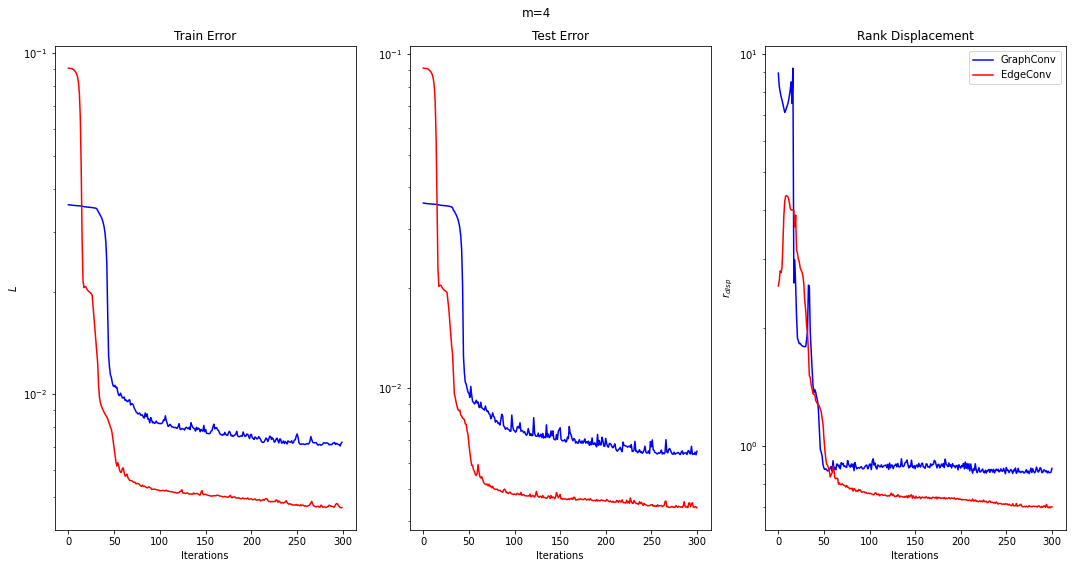

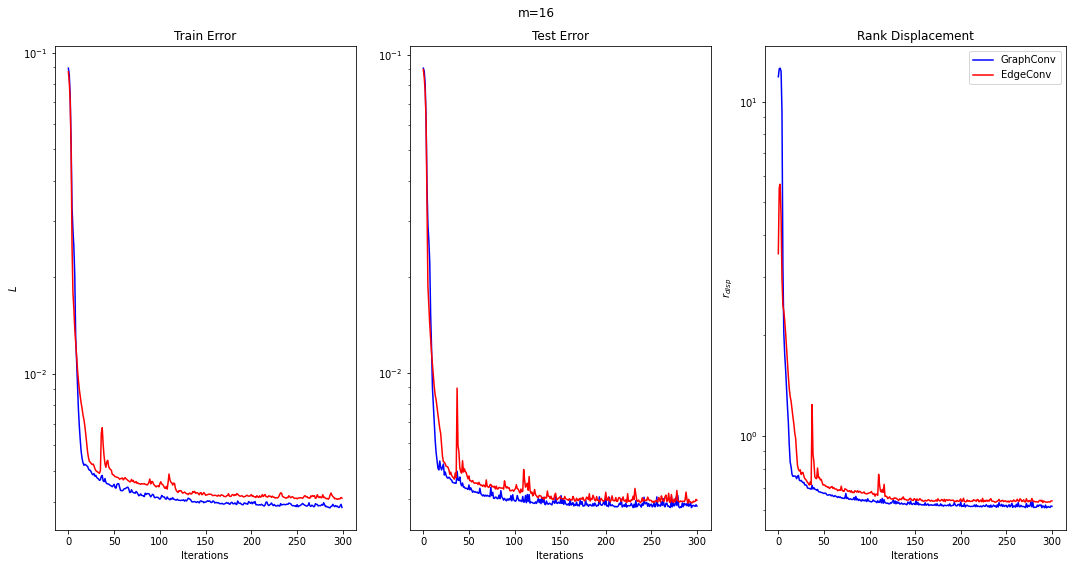

In [17]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph4_metrics[0],color='blue')
plt.semilogy(edge4_metrics[0],color='red')
plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph4_metrics[1],color='blue')
plt.semilogy(edge4_metrics[1],color='red')
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph4_metrics[2],color='blue',label='GraphConv')
plt.semilogy(edge4_metrics[2],color='red',label='EdgeConv')
plt.title('Rank Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend()
plt.suptitle("m=4")

plt.tight_layout();
plt.show()

plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph16_metrics[0],color='blue')
plt.semilogy(edge16_metrics[0],color='red')
plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph16_metrics[1],color='blue')
plt.semilogy(edge16_metrics[1],color='red')
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph16_metrics[2],color='blue',label='GraphConv')
plt.semilogy(edge16_metrics[2],color='red',label='EdgeConv')
plt.title('Rank Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend()
plt.suptitle("m=16")

plt.tight_layout();


We plot a) training loss b) test loss and c) average rank displacement. With this larger eigenvalue ratio, there is a clear degredation in GCN performance. Indeed, the test loss now hovers around $8e^{-3}$ ($m=4$) and $4e^{-3}$ ($m=16$) for GraphConv and between from $5e^{-3}$ to $4e^{-3}$ for EdgeConv. While all our GCNs surpass the associated $q=4$ truncated sum, their losses are still each nearly two orders of magnitude worse than for the best model on the high-density dataset. 

## Deeper (and Wider) GCNs

So our results in the prior section obviously beget the question: can we do better? We don't want a model that is actively worse at learning structure for a large (and arguably quite common) class of networks; at the very least, we would like to minimize the difference in centrality prediction between high and low-density networks, which we term the *topological performance gap*. Going back to one of our definitions for $d_{Katz}$, 

$$d_{Katz} = \vec{\beta} + \sum_{k=1}^{n} (\alpha{}A)^{k}\vec{1} + \vec{v_{1}}\sum_{k=n+1}^{\infty}\alpha{}^{k}$$

it seems fairly obvious that a larger $l_{max}$ should lead to a closer approximation of the first term. To verify this, we train an $m=16$ GraphConv model for all $l_{max}=1,2,4,..,64$ and report convergence. We also train a set of $l_{max}=4$ models while varying $m$ from $4$ to $256$, which allows us to assess the impact of an increased parameter count without any associated change in the number of convolutions. Since EdgeConv did not seem to offer any unanimous benefit before, we exclude it from these experiments.

### Varying Width

In [18]:
width_results = []
for k in [4,8,16,32,64,128,256]:
    torch.manual_seed(0)
    model = GraphConv(1,k,1,4).cuda()
    
    width_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-3))

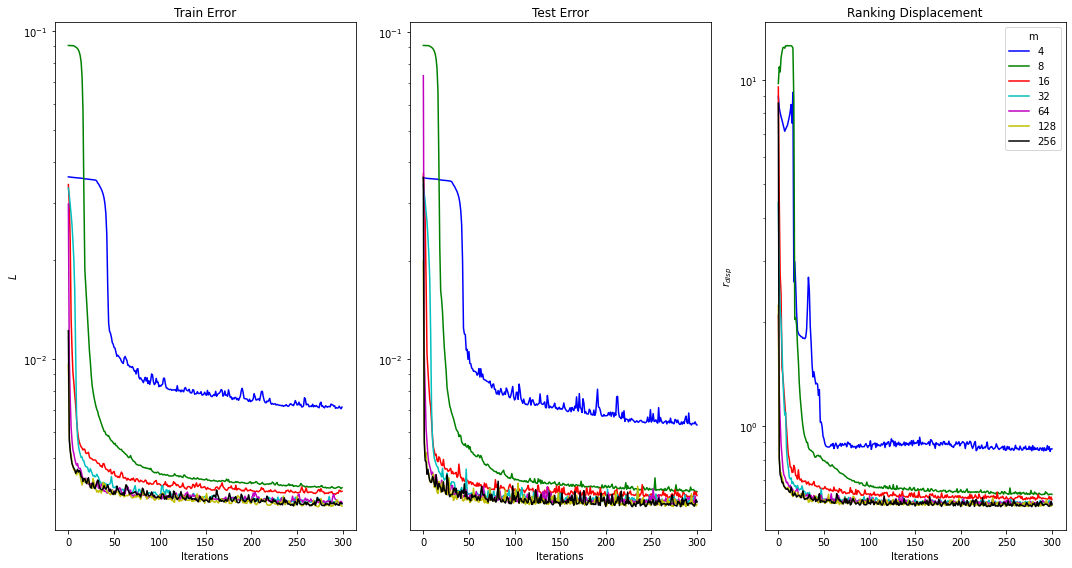

In [19]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(width_results[i][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(width_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([4,8,16,32,64,128,256]):
  plt.semilogy(width_results[idx][2],label=alpha)
plt.title('Ranking Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend(title='m')

plt.tight_layout();

Above, we plot a) training loss b) test loss and c) average rank displacement for the $l_{max}=4$ model as width $m$ goes from $4$ to $128$. The figure below shows the average values on the train and test loss over the last 10 epochs versus $m$. 

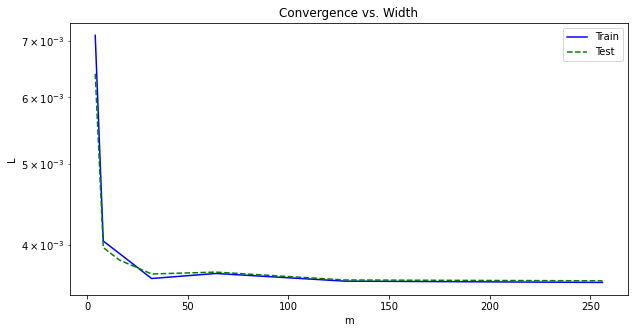

In [20]:
plt.figure(figsize=(10,5))
params = [4,8,16,32,64,128,256]
plt.semilogy(params,[np.mean(width_results[i][0][-10::]) for i in range(7)],label='Train')
plt.semilogy(params,[np.mean(width_results[i][1][-10::]) for i in range(7)],linestyle='--',label='Test')
plt.legend();
plt.xlabel('m')
plt.ylabel('L');
plt.title('Convergence vs. Width');

Our model's performance has minimal dependence on width, and, despite some initial benefit, increasing $m$ past $m=8$ is subject to rapidly diminishing returns. Indeed, the loss essentially stagnates for all $m\geq{}32$. This is not an issue of overfitting, as both the train and test losses flatten out. All in all, we take this as confirmation that we cannot sufficiently address the topological performance gap simply by adding more parameters.

### Varying Depth

In [21]:
depth_results = []
depth_metrics = []
for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    model = GraphConv(1,16,1,k).cuda()
    
    depth_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-3))
    torch.cuda.empty_cache()
    
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
  # Iterate over dataset and average metrics
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        edge_index,edge_weight = data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        model.eval()
        X = model.start(X)
        
        # Iterate over model layers
        for jdx,m in enumerate(model.intermediate):
            X =  m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch])
            
            # Compute MAD
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            
            # Compute AggNorm
            GFS[jdx] += batched_GFS(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            
            #Compute Normalized Rayleigh
            Ray[jdx] += rayleigh_quotient(X,edge_index,edge_weight,batch,data.eig_max.cuda(),data.eig_min.cuda()).mean().item()
            
    depth_metrics.append([MAD/(idx+1),GFS/(idx+1),Ray/(idx+1)])

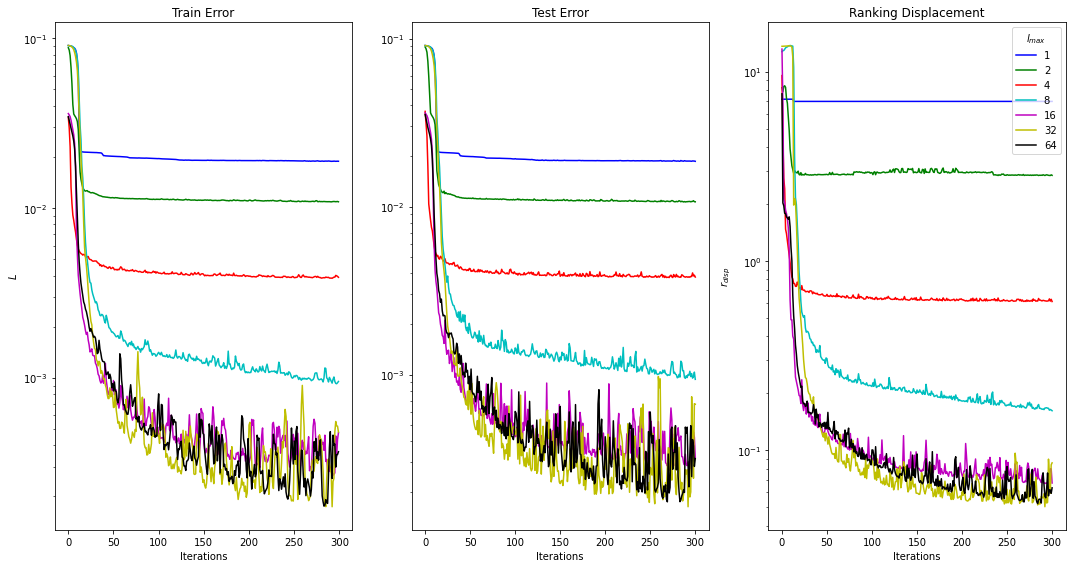

In [22]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(depth_results[i][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(depth_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(depth_results[idx][2],label=alpha)
plt.title('Ranking Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend(title='$l_{max}$')

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for the $m=16$ model with $l_{max}=1,2,4,...,64$. The figure below shows the average values on the train and test loss over the last 10 epochs versus $l_{max}$. 

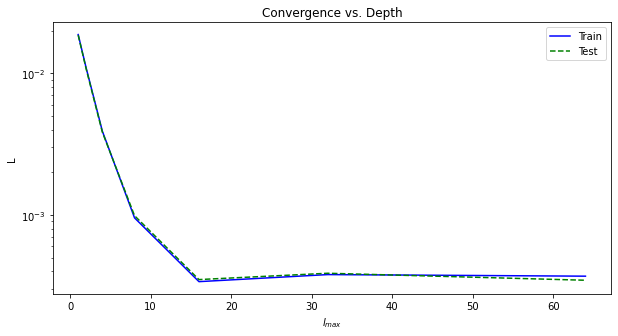

In [23]:
plt.figure(figsize=(10,5))
params = [1,2,4,8,16,32,64]
plt.semilogy(params,[np.mean(depth_results[i][0][-10::]) for i in range(7)],label='Train')
plt.semilogy(params,[np.mean(depth_results[i][1][-10::]) for i in range(7)],linestyle='--',label='Test')
plt.legend();
plt.xlabel('$l_{max}$')
plt.ylabel('L');
plt.title('Convergence vs. Depth');

As expected, increasing GCN depth boosts performance (much more so than a greater width), and our deepest models handily outperform their corresponding truncated sum approximations. However, the losses do begin to stagnate with respect to depth for $l_{max}\geq{}16$. One would think we'd see continual improvement versues $l_{max}$, but instead it looks like $4e^{-4}$ is a soft minimum of sorts. We suspect GraphConv is either a) having difficulty backpropagating due to the greater model depth or b) running into oversmoothing with the increased number of convolutions.

### Adding Residual Connections

To assess whether network depth is having adverse effects on backpropagation, we train an $l_{max}=64$ GraphConv model with 1-hop residual connections following each non-linearity, which have been shown to improve the stability and performance of deeper GCNs [15]. If there is truly an issue, then we should expect to see improvement over the non-residual model.

In [24]:
class ResidualGraphConv(torch.nn.Module):
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth):
        super(ResidualGraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        # Run through GraphConv layers
        for idx,m in enumerate(self.intermediate):
            nX = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = X + torch.nn.LeakyReLU()(nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch])
            
        # Project to out_channels
        return self.finish(X)

In [25]:
residual_results = []

torch.manual_seed(0)
graph = ResidualGraphConv(1,16,1,64).cuda()

residual_results.append(train_loop(graph,train_loader,test_loader,300,lr=1e-3))
torch.save(residual_results,'residual_results{}'.format(32))
torch.cuda.empty_cache()

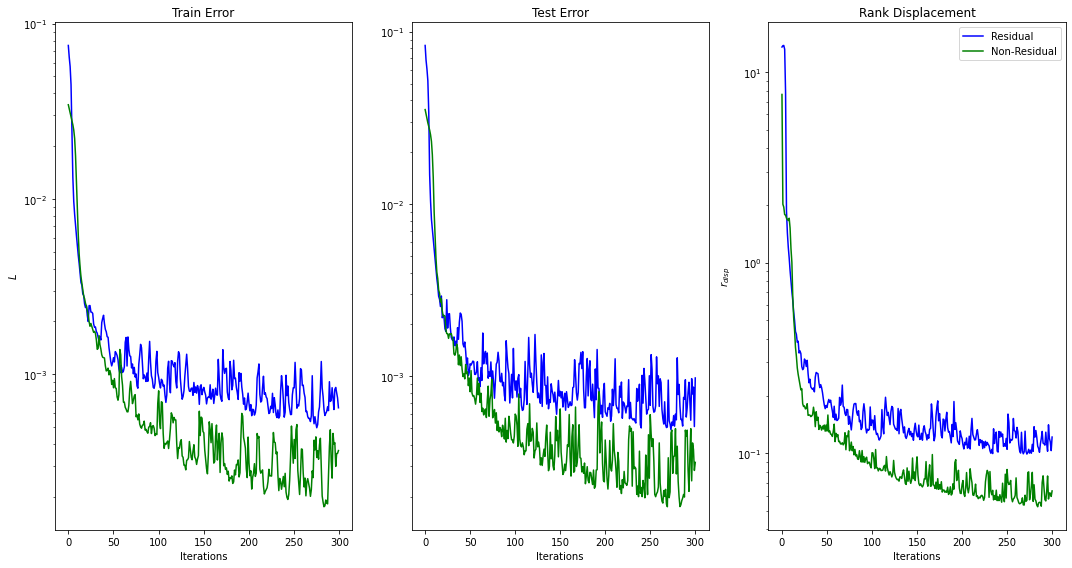

In [26]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(residual_results[0][0])
plt.semilogy(depth_results[-1][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(residual_results[0][1])
plt.semilogy(depth_results[-1][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(residual_results[0][2],label='Residual')
plt.semilogy(depth_results[-1][2],label='Non-Residual')

plt.title('Rank Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. Adding residual connections actually appears to hampen the model. We suspect this occurs because we are now implicitly aggregating with $(2I + A)$, which may very well increase the ratio of leading eigenvalues for most of the dataset. Regardless, these result contradict the notion that our deeper models are underperforming due to backpropgation issues.

### GCN Smoothing and Normalization

And this leads us nicely into a pet topic of mine. GCNs suffer from a peculiar phenomena known as *oversmoothing*. In essence, as you add more layers, the features of each node converge to fixed values and accuracy tends to deteriorate. Current theoretical analysis of oversmoothing has been focused on the GCNConv operator of Kipf and Welling [15].

$$X^{l+1} = (\hat{D}^{\frac{-1}{2}}\hat{A}\hat{D}^{\frac{-1}{2}})X^{l}W$$
$$ \hat{A} = I + A \; \; \; \; \hat{D} = \hat{A}\vec{1}$$

This is a psuedo-spectral convolution, in it that aggregates using a form of the symmetric normalized graph Lapalcian $L_{sym} = I - D^{\frac{-1}{2}}AD^{\frac{-1}{2}}$. By definition, $L_{sym}$ possesses eigenvalues $0\leq{}\lambda_{i}\leq{}2$. We are  guaranteed an eigenvector $v_{i}=D^{\frac{1}{2}}\vec{1}$ for $i$ such that $\lambda_{i}=0$, and dropping $I$ shifts the spectra, making $v_{i}$ dominant. The asymptoptic behavior of the GCNConv aggregation step is to therefore diffuse material until it is distributed according to the square root of the augmented node degree $\hat{D}$. Since most real-life networks possess approximately power-law degree distributions, the majority of nodes will eventually become indistinguishable; this is the root of the oversmoothing problem in GCNConv. However, the literature demonstrates that spatial convolution algorithms, which do not explicitly incorporate $L_{sym}$, are no less vulnerable [14,16] to oversmoothing. As an example, we train our GraphConv model (both with and without any normalization) on the Cora node classification benchmark and report on the smoothness of its intermediate representations. We choose to measure this by the sparsified Mean Average Distance (MAD) [14],

$$MAD(X^{l},E,V) = \frac{1}{|V|}\sum_{i\in{V}}(\frac{1}{\sum_{i,j\in{}E}w_{ij}}\sum_{i,j\in{}E}w_{ij}(1 - \frac{|(x_{j}^{l})^{T}x^{l}_{i}|}{||x^{l}_{i}||_{2}||x^{l}_{j}||_{2}}))$$

Global Feature Similarity (or GFS),

$$GFS(X^{l},E,V) = \frac{2}{m(m-1)}\sum_{i=0}^{m}\sum_{j=i+1}^{m}(1 - \frac{|(X_{:,i}^{l})^{T}X_{:,j}^{l}|}{||X^{l}_{:,i}||_{2}||X^{l}_{:,j}||_{2}})$$

and the absolute Rayleigh Quotient,

$$R(X^{l},A,V) = \frac{1}{|V|}\sum_{i\in{}V}(\frac{1}{\lambda_{max}-\lambda_{min}}(\lambda_{max} - |\frac{\vec{x}^{l}_{i}A\vec{x}^{l}_{i}}{\vec{x}^{l}_{i}\cdot{}\vec{x}^{l}_{i}}|))$$

with MinMax normalization. $\lambda_{max}$ and $\lambda_{min}$ are the eigenvalues of $A$ with, respectively, the largest and smallest absolute values. MAD quantifies the similarity of adjacent nodes, whereas GFS measures how close the columns $X_{:,i}^{l}$ are to one another. Both employ the cosine distance for scale invariance. The normalized Rayleigh Quotient reflects how close each column is to the dominant eigenvector $v_{1}$, with $R(X^{l})=0$ indicating they are equivalent. 

#### Cora Example

In [27]:
def citeseer_train_loop(model,data,epochs,lr=1e-3):
    train_loss = []
    test_loss = []

    try: opt = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
    except: pass;
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    model.eval()
    with torch.no_grad():
        X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        preds = model(X,edge_index,edge_weight,batch)
        test_loss.append(torch.mean((preds[data.test_mask].argmax(dim=1)==Y[data.test_mask]).float()))

    for epoch in range(epochs):
        model.train()
        X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        preds = model(X,edge_index,edge_weight,batch)

        loss = torch.nn.CrossEntropyLoss()(preds[data.train_mask],Y[data.train_mask])
        train_loss.append(torch.mean((preds[data.train_mask].argmax(dim=1)==Y[data.train_mask]).float()))

        loss.backward()
        opt.step()
        opt.zero_grad()

            
        model.eval()
        with torch.no_grad():
            X,Y,edge_index,edge_weight = data.x.cuda(),data.y.cuda(),data.edge_index.cuda(),data.edge_weight.cuda()
            batch = data.batch.cuda()

            preds = model(X,edge_index,edge_weight,batch)
            test_loss.append(torch.mean((preds[data.test_mask].argmax(dim=1)==Y[data.test_mask]).float()))

    return train_loss,test_loss

In [28]:
citeseer = torch_geometric.datasets.Planetoid('.','Cora',split="full")[0]
citeseer.edge_index = torch_geometric.utils.to_undirected(citeseer.edge_index)
citeseer.x = citeseer.x/(1e-4 + torch.norm(citeseer.x,dim=1))[:,None]

citeseer.edge_weight = torch.ones((citeseer.edge_index.shape[1]))
citeseer.batch = torch.zeros((citeseer.x.shape[0])).long()
val = torch.eig(torch_sparse.SparseTensor(row=citeseer.edge_index[0],col=citeseer.edge_index[1],
                                          value=citeseer.edge_weight).to_dense())[0]
val = torch.norm(val,dim=1)
citeseer.eig_min = val.min() * torch.ones((1))
citeseer.eig_max = val.max() * torch.ones((1))

In [29]:
citeseer_metrics = []
citeseer_metrics2 = []


for k in [1,2,4,8,16]:
    torch.manual_seed(0)
    model = GraphConv(citeseer.x.shape[-1],16,len(citeseer.y.unique()),k,norm=False).cuda()

    _ = citeseer_train_loop(model,citeseer,200,lr=1e-2)
    
    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    X = citeseer.x.cuda()
    row,col = citeseer.edge_index[0].cuda(),citeseer.edge_index[1].cuda()
    batch = citeseer.batch.cuda()

    model.eval()
    X = model.start(X)
        
    for jdx,m in enumerate(model.intermediate):
        X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
        X = torch.nn.LeakyReLU()(X)
        
        MAD[jdx] += batched_MAD(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda()).mean().item()
        GFS[jdx] += batched_GFS(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),batch).item()
        Ray[jdx] += rayleigh_quotient(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),
                                batch,citeseer.eig_max.cuda(),citeseer.eig_min.cuda()).item()
            
    citeseer_metrics.append([MAD,GFS,Ray])
    
    torch.manual_seed(0)
    model = GraphConv(citeseer.x.shape[-1],16,len(citeseer.y.unique()),k,norm=True).cuda()

    _ = citeseer_train_loop(model,citeseer,200,lr=1e-2)
    
    # Iterate through network layers and compute the MAD/Agg at each
    MAD,GFS,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    X = citeseer.x.cuda()
    row,col = citeseer.edge_index[0].cuda(),citeseer.edge_index[1].cuda()
    batch = citeseer.batch.cuda()

    model.eval()
    X = model.start(X)
        
    for jdx,m in enumerate(model.intermediate):
        X = m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
        X = torch.nn.LeakyReLU()(X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch])
        
        MAD[jdx] += batched_MAD(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda()).mean().item()
        GFS[jdx] += batched_GFS(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),batch).item()
        Ray[jdx] += rayleigh_quotient(X,citeseer.edge_index.cuda(),citeseer.edge_weight.cuda(),
                                batch,citeseer.eig_max.cuda(),citeseer.eig_min.cuda()).item()
            
    citeseer_metrics2.append([MAD,GFS,Ray])
    torch.cuda.empty_cache()

Below we plot the minimum, mean, and standard deviations of MAD, GFS, and $R$ on Cora across all layers versues $l_{max}$. We justify looking at the minimum in that, once oversmoothing occurs in any given layer, the network will be unable to recover information regarding the node features. It may happen upon less smooth representations in subsequent layers, but they are going to be independent of the input. The mean and standard deviation, on the other hand, allow us insight into the uniformity of oversmoothing i.e: how atypical is the minimum.

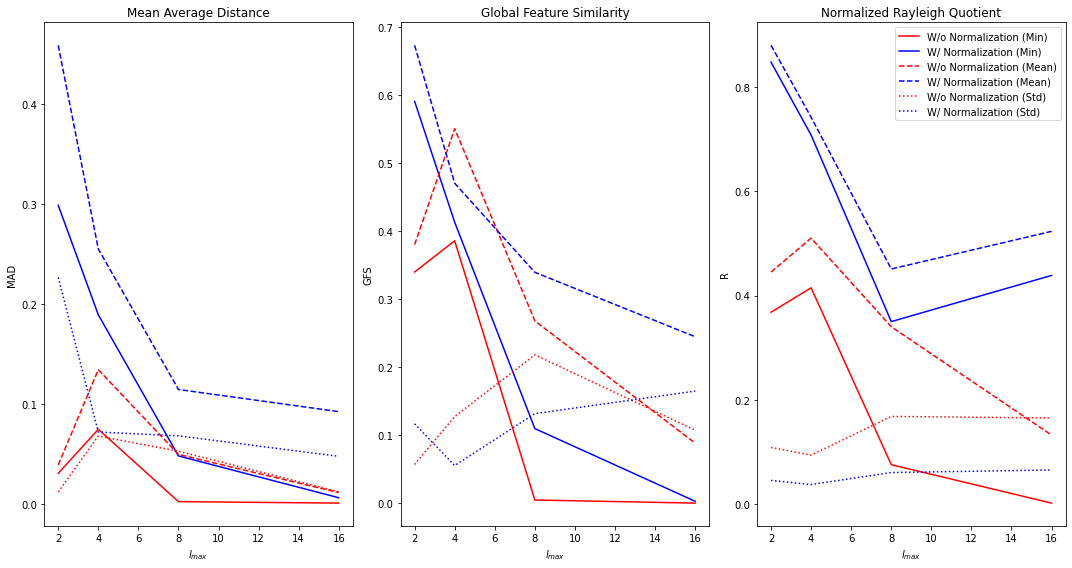

In [37]:
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    mad.append(citeseer_metrics[idx+1][0].min().item())
    mad2.append(citeseer_metrics2[idx+1][0].min().item())
  plt.plot([2,4,8,16],mad,c='r')
  plt.plot([2,4,8,16],mad2,c='b')
    
  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    mad.append(citeseer_metrics[idx+1][0].mean().item())
    mad2.append(citeseer_metrics2[idx+1][0].mean().item())
  plt.plot([2,4,8,16],mad,c='r',linestyle='--')
  plt.plot([2,4,8,16],mad2,c='b',linestyle='--')
    
    
  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    mad.append(citeseer_metrics[idx+1][0].var().sqrt().item())
    mad2.append(citeseer_metrics2[idx+1][0].var().sqrt().item())
  plt.plot([2,4,8,16],mad,c='r',linestyle=':')
  plt.plot([2,4,8,16],mad2,c='b',linestyle=':')
    
  plt.xlabel('$l_{max}$')
  plt.ylabel('MAD')
  plt.title('Mean Average Distance')

  plt.subplot(1,3,2)
  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    gfs.append(citeseer_metrics[idx+1][1].min().item())
    gfs2.append(citeseer_metrics2[idx+1][1].min().item())
  plt.plot([2,4,8,16],gfs,c='r')
  plt.plot([2,4,8,16],gfs2,c='b')
    
  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    gfs.append(citeseer_metrics[idx+1][1].mean().item())
    gfs2.append(citeseer_metrics2[idx+1][1].mean().item())
  plt.plot([2,4,8,16],gfs,c='r',linestyle='--')
  plt.plot([2,4,8,16],gfs2,c='b',linestyle='--')
    
  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    gfs.append(citeseer_metrics[idx+1][1].var().sqrt().item())
    gfs2.append(citeseer_metrics2[idx+1][1].var().sqrt().item())
  plt.plot([2,4,8,16],gfs,c='r',linestyle=':')
  plt.plot([2,4,8,16],gfs2,c='b',linestyle=':')
    
  plt.xlabel('$l_{max}$')
  plt.ylabel('GFS')
  plt.title('Global Feature Similarity')

  plt.subplot(1,3,3)
  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    ray.append(citeseer_metrics[idx+1][2].min().item())
    ray2.append(citeseer_metrics2[idx+1][2].min().item())
  plt.plot([2,4,8,16],ray,label='W/o Normalization (Min)',c='r')
  plt.plot([2,4,8,16],ray2,label='W/ Normalization (Min)',c='b')
    
  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    ray.append(citeseer_metrics[idx+1][2].mean().item())
    ray2.append(citeseer_metrics2[idx+1][2].mean().item())
  plt.plot([2,4,8,16],ray,label='W/o Normalization (Mean)',linestyle='--',c='r')
  plt.plot([2,4,8,16],ray2,label='W/ Normalization (Mean)',linestyle='--',c='b')
    
  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16]):
    ray.append(citeseer_metrics[idx+1][2].var().sqrt().item())
    ray2.append(citeseer_metrics2[idx+1][2].var().sqrt().item())
  plt.plot([2,4,8,16],ray,label='W/o Normalization (Std)',linestyle=':',c='r')
  plt.plot([2,4,8,16],ray2,label='W/ Normalization (Std)',linestyle=':',c='b')
    
  plt.xlabel('$l_{max}$')
  plt.ylabel('R')
  plt.title('Normalized Rayleigh Quotient')
  plt.legend()

  plt.tight_layout()
  plt.show()

As $l_{max}$ increases, we observe the following:
  - The minimum MAD and GFS for our normalized and unnormalized models both converge to $0$ as $l_{max}\rightarrow{}16$. This indicates that at some layer 1) adjacent nodes are almost entirely homogenous and 2) all the features are identical bar a scale factor. Our mean metrics are, in general, a fair bit higher than the minimums, and here there is much more of a gap between the two GCNs. Interestingly, the standard deviation of GFS for the normalized model increases steadily with $l_{max}$, though we'd need to look layer-by-layer to really prescribe any great meaning to this.

  - $R$ is the most curious part of the picture here. While GFS and MAD would suggest that our deepest models are fairly similar with or without normalization (their minimums are close, the means both trend downwards, etc.), the two end up converging to very different values of $R$. Not only this, but they appear to be moving in opposite directions; if we raised $l_{max}$ further, the unnormalized model would likely have a smaller $R$ whereas the normalized one would see an increase. This essentially means that, while the former is approaching $v_{1}$ in more and more layers, the latter is actively getting less similar to the dominant eigenvector. Coupled with this, the standard deviation is also small and nigh-constant, so the minimum $R$ (and the growing gap between mean and minimum) seems rather spurious.

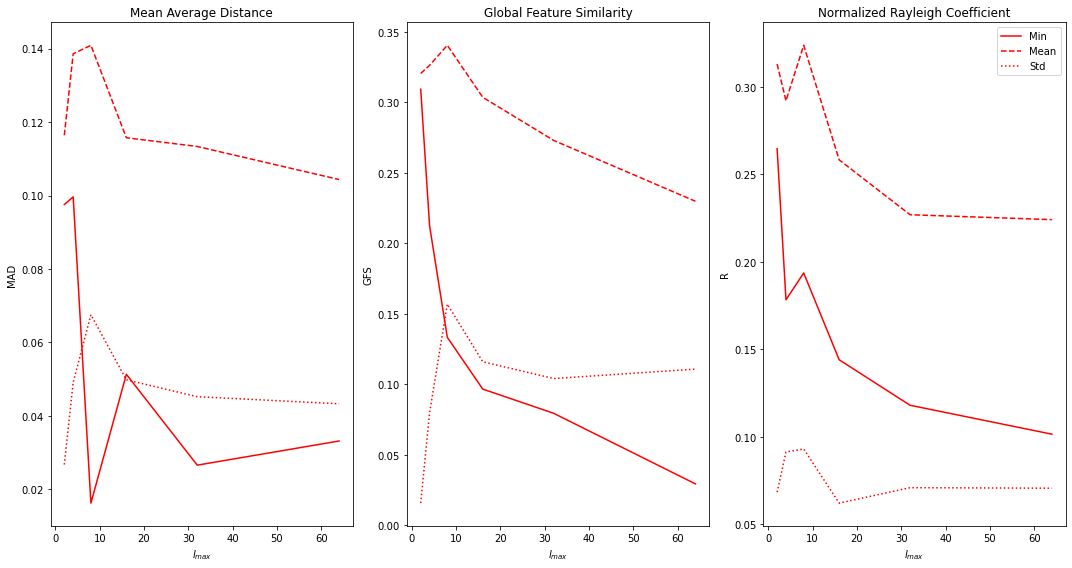

In [40]:
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    mad.append(depth_metrics[idx+1][0].min().item())
  plt.plot([2,4,8,16,32,64],mad,c='r')

  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    mad.append(depth_metrics[idx+1][0].mean().item())
  plt.plot([2,4,8,16,32,64],mad,c='r',linestyle='--')

  mad,mad2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    mad.append(depth_metrics[idx+1][0].var().sqrt().item())
  plt.plot([2,4,8,16,32,64],mad,c='r',linestyle=':')
  plt.xlabel('$l_{max}$')
  plt.ylabel('MAD')
  plt.title('Mean Average Distance')

  plt.subplot(1,3,2)
  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    gfs.append(depth_metrics[idx+1][1].min().item())
  plt.plot([2,4,8,16,32,64],gfs,c='r')

  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    gfs.append(depth_metrics[idx+1][1].mean().item())
  plt.plot([2,4,8,16,32,64],gfs,c='r',linestyle='--')

  gfs,gfs2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    gfs.append(depth_metrics[idx+1][1].var().sqrt().item())
  plt.plot([2,4,8,16,32,64],gfs,c='r',linestyle=':')

  plt.xlabel('$l_{max}$')
  plt.ylabel('GFS')
  plt.title('Global Feature Similarity')

  plt.subplot(1,3,3)
  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    ray.append(depth_metrics[idx+1][2].min().item())
  plt.plot([2,4,8,16,32,64],ray,c='r',label='Min')

  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    ray.append(depth_metrics[idx+1][2].mean().item())
  plt.plot([2,4,8,16,32,64],ray,c='r',linestyle='--',label='Mean')

  ray,ray2 = [],[]
  for idx,l in enumerate([2,4,8,16,32,64]):
    ray.append(depth_metrics[idx+1][2].var().sqrt().item())
  plt.plot([2,4,8,16,32,64],ray,c='r',linestyle=':',label='Std')

  plt.xlabel('$l_{max}$')
  plt.ylabel('R')
  plt.title('Normalized Rayleigh Coefficient')
  plt.legend()

  plt.tight_layout()
  plt.show()

The above figure shows the aggregated a) MAD b) GFS and c) $R$ for our GraphConv models trained on the low-density dataset. MAD does not change a whole lot as we increase $l_{max}$; the minimum spikes early, but otherwise oscillates around $.03$, and the mean always remains close to $.12$. Our minimum GFS uniformly decays towards $0.0$, although the mean remains quite high at $.25$. Minimum $R$ looks to be converging to $.1$. However, the standard deviation is quite small, and so layer-by-layer $R$ is much more clustered around the mean, which flattens out at around $.23$. This suggests that the minimum is the result of a profound, unexpected oscillation, as opposed to a measured decline across layers. 

#### OrthNorm

Now, as far as learning $d_{Katz}$ is concerned, this all presents a big issue. Oversmoothing is actually somewhat necesary for learning this type of graph structure, as we ideally want to converge to something close (but no too close) to $v_{1}$. Normalization would appear to inhibit this, but, by the same measure, $l_{max}>16$ models can otherwise be quite unstable. Moreover, we cannot know *a prior* whether encoding $v_{1}$ would even be beneficial to a given graph learning task, so simply dropping all normalization is not a good idea. 

To this end, we propose the following normalization scheme, which we tentatively call OrthNorm:

$$X_{:,i}^{l} = X^{l}_{:,i} - \sigma{}(\gamma_{i})\frac{(\vec{v_{1}}')^{T}X^{l}_{:,i}}{||\vec{v_{1}}'||_{2}^{2}}\vec{v_{1}}'$$
$$X_{:,i}^{l} = \frac{X_{:,i}^{l}}{1 + \sigma{}(\beta_{i})(||X_{:,i}^{l}||_{2} - 1)}$$

where $\vec{v_{1}}'\in{}R^{|V|}$ is an estimate of the dominant eigenvector. By varying $\vec{\gamma}$ and $\vec{\beta}$, the model can regulate the approximate similarity of each $X_{:,i}$ to $v_{1}$. This addresses each of our above concerns; if we don't want to capture $v_{1}$ (or simply not have the $ith$ feature converge to it), then we explicitly learn $\sigma{}(\vec{\gamma_{i}}),\sigma{}(\vec{\beta{i}})=1$, and earlier layers can also remain normalized to prevent instability. Our method may be viewed as a generalization of PairNorm with individual scaling [16].

$$X_{:,i}^{l} = X_{:,i}^{l} - \frac{1}{n}\sum_{i=0}^{n}X_{:,i}^{l}$$
$$X_{:,i}^{l} = s \frac{X_{:,i}^{l}}{||X_{:,i}^{l}||_{2}}$$

It is also fairly similar in principle to the GraphNorm operator of [21]:

$$ X^{l} = \gamma{} \circ{} \frac{X - \alpha{} E[X]}{\sqrt{E[(X - \alpha{}E[X])^{2}]}} + \beta{}$$

We conduct ablation studies for $\vec{v_{1}}'=\vec{1},\vec{d}_{degree}, \frac{A^{5}\vec{1}}{||A^{5}\vec{1}||_{2}^{2}}$ at $l_{max}=64$, $m=16$ and compare against our previous models. This involes looking at train/test loss, $r_{disp}$, MAD, etc. We also explore the importance of the $\vec{\gamma{}}$ and $\vec{\beta}$ parameters, in addition to whether the network possesses any 1-hop residual connections. Note: $\eta{}=1e^{1}$ appears to work best for this type of normalization.

In [41]:
# Compute ones vector
def identity(X,edge_index,edge_weight,batch):
    return torch.ones(X.shape[0]).cuda()[batch,None]

# Compute degree
def degree(X,edge_index,edge_weight,batch):
    return  torch_geometric.utils.degree(edge_index[0]).cuda()[:,None]

# Compute a quick power iteration approximation 
def step(X,edge_index,edge_weight,batch):
    Z = torch.ones((X.shape[0],1)).cuda()
    with torch.no_grad():
            for _ in range(5):
                Z = torch_scatter.scatter_sum(edge_weight[:,None] * Z[edge_index[1]], edge_index[0],dim=0)/20
            Z = Z/torch_scatter.scatter_sum(Z**2,batch,dim=0).sqrt()[batch]
    return Z

In [42]:
# Class for the OrthNorm
class OrthNorm(torch.nn.Module):
    def __init__(self,q,int_channels,grad=True):
        super(OrthNorm,self).__init__()
        self.q = q

        # Scale parameters
        if grad:
            self.s1 = torch.nn.Parameter(torch.zeros(int_channels),requires_grad=grad)
            self.s2 = torch.nn.Parameter(torch.zeros(int_channels),requires_grad=grad)
        else:
            self.s1 = torch.nn.Parameter(10 * torch.ones(int_channels),requires_grad=grad)
            self.s2 = torch.nn.Parameter(10 * torch.ones(int_channels),requires_grad=grad)

    def forward(self,X,edge_index,edge_weight,batch):
        
        # Compute q
        q = self.q(X,edge_index,edge_weight,batch)
        q_norm = torch_scatter.scatter_sum(q**2,batch,dim=0)
        
        # Compute scalar projection of X onto q
        alpha = torch_scatter.scatter_sum(X * q,batch,dim=0)/(q_norm)
        
        # Compute OrthNorm
        X = X - torch.sigmoid(self.s1)[None,:] * (alpha)[batch] * q
        X_norm = torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()
        X = X/(1 + torch.sigmoid(self.s2)[None,:] * (X_norm - 1))[batch]
        return X
    
# This is a GraphConv model which we can plug various normalization schemes into.
class DummyModel(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,depth,norm,q,grad=True,res=False):
        super(DummyModel,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.norm = torch.nn.ModuleList([norm(q,int_channels,grad) for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        self.res = res

    def forward(self,X,edge_index,edge_weight,batch):
        X = self.start(X)
        for idx,m in enumerate(self.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            Update = torch.nn.LeakyReLU()(self.norm[idx](Update,edge_index,edge_weight,batch))
            
            if self.res: X = X + Update
            else: X = Update

            if torch.isnan(X).any(): raise ValueError
        return self.finish(X)

In [43]:
# A helper function to compute various metrics
def get_metrics(model,test_loader,k=64):

  # Layerwise MAD
  model_mad = []
    
  # Layerwise AggNorm
  model_gfs = []
    
  # Normalized Rayleigh
  model_ray = []
    
  # S1 parameter
  model_s = []

  MAD,GFS,Ray,S = torch.zeros(k),torch.zeros(k),torch.zeros(k),torch.zeros((2,k))
    
  # Iterate over dataset and average metrics
  for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        edge_index,edge_weight = data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        model.eval()
        X = model.start(X)
        
        # Iterate over model layers
        for jdx,m in enumerate(model.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)

            if model.res: X = X + Update
            else: X = Update
            X = torch.nn.LeakyReLU()(model.norm[jdx](X,edge_index,edge_weight,batch))

            # Fetch S1 and S2
            S[0,jdx] += torch.sigmoid(model.norm[jdx].s1).mean().item()
            S[1,jdx] += torch.sigmoid(model.norm[jdx].s2).mean().item()
            
            # Compute MAD
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            
            # Compute AggNorm
            GFS[jdx] += batched_GFS(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            
            #Compute Normalized Rayleigh
            Ray[jdx] += rayleigh_quotient(X,edge_index,edge_weight,batch,data.eig_max.cuda(),data.eig_min.cuda()).mean().item()
        
  model_mad.append(MAD/(idx+1))
  model_gfs.append(GFS/(idx+1))
  model_ray.append(Ray/(idx+1))
  model_s.append(S/(idx+1))

  # Return metrics
  return (model_mad,model_gfs,model_ray,model_s)

In [44]:
identity_results = []
identity_metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,identity).cuda()

identity_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
identity_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,identity,res=True).cuda()

identity_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
identity_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,identity,grad=False).cuda()

identity_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
identity_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,identity,res=True,grad=False).cuda()

identity_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
identity_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

In [45]:
degree_results = []
degree_metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,degree).cuda()

degree_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
degree_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,degree,res=True).cuda()

degree_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
degree_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,degree,grad=False).cuda()

degree_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
degree_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,degree,res=True,grad=False).cuda()

degree_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
degree_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

In [46]:
step_results = []
step_metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,step).cuda()

step_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
step_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,step,res=True).cuda()

step_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
step_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,step,grad=False).cuda()

step_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
step_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,16,1,64,OrthNorm,step,res=True,grad=False).cuda()

step_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
step_metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

In [51]:
import pandas as pd
best_table = []
best_table.append([np.mean(identity_results[i][1][-10:]) for i in range(4)])
best_table.append([np.mean(degree_results[i][1][-10:]) for i in range(4)])
best_table.append([np.mean(step_results[i][1][-10:]) for i in range(4)])

table = pd.DataFrame(best_table)
table.columns = ['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']
table.index = ['Ones','Degree','PowerIter']
table

,"NonRes,Grad",ResGrad,"NonRes,NoGrad","Res,NoGrad"
Ones,0.000074,0.000057,0.001370,0.000619
Degree,0.000065,0.000053,0.001210,0.001390
PowerIter,0.000223,0.000042,0.001119,0.000702


Our best score on the test loss is $4.2e^{-5}$ , which is obtained for $\vec{v_{1}}'=\frac{A^{5}\vec{1}}{||A^{5}\vec{1}||_{2}^{2}}$ (listed as PowerIter) with both residual connections and enabled gradients on $\gamma{}$ and $\beta$. For comparison, our earlier $l_{max}=64$ model with simple column-wise normaliztion converged to about $3e^{-4}$, and it corresponds to the case of $\sigma(\gamma{})=0$,$\sigma(\beta{})=1$. When we fix $\sigma(\gamma{}),\sigma(\beta)=1$, there is a substantial drop in performance for all choices of $\vec{v_{1}}'$, so clearly these parameters are responsible for any improvement offered by OrthNorm. Residual connections are useful, although their benefit is only all that pronounced for PowerIter and the $\vec{v_{1}}'=\vec{1}$ (Ones) NoGrad model. 

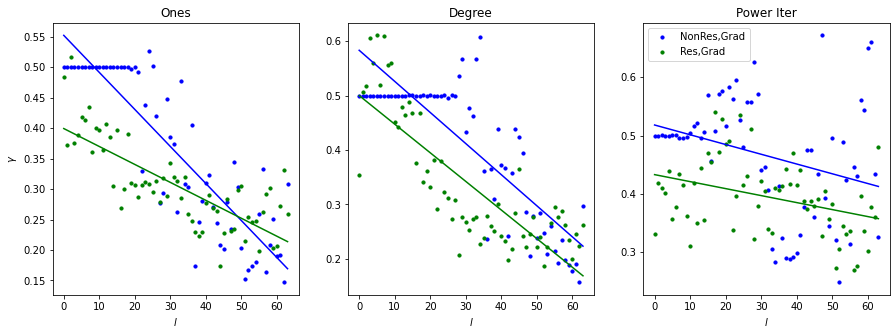

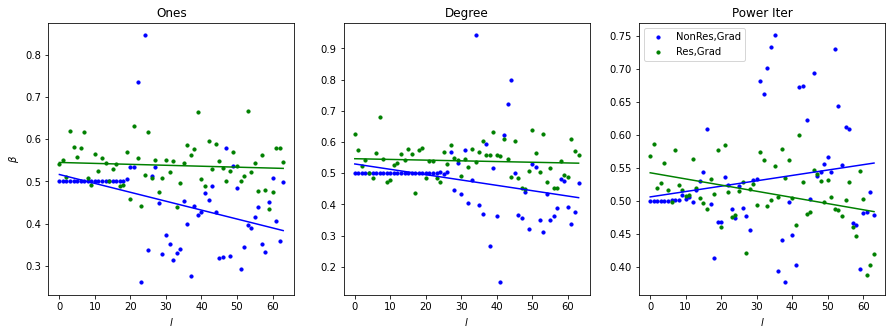

In [48]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(range(64),(identity_metrics[0][-1][0][0]),label='NonRes,Grad',s=10)
m,b = np.polyfit(range(64), identity_metrics[0][-1][0][0], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.scatter(range(64),(identity_metrics[1][-1][0][0]),label='Res,Grad',s=10)
m,b = np.polyfit(range(64), identity_metrics[1][-1][0][0], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.ylabel('$\gamma$')
plt.title("Ones")
plt.xlabel('$l$');

plt.subplot(1,3,2)
plt.scatter(range(64),(degree_metrics[0][-1][0][0]),label='NonRes,Grad',s=10)
m,b = np.polyfit(range(64), degree_metrics[0][-1][0][0], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.scatter(range(64),(degree_metrics[1][-1][0][0]),label='Res,Grad',s=10)
m,b = np.polyfit(range(64), degree_metrics[1][-1][0][0], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.title("Degree")
plt.xlabel('$l$');

plt.subplot(1,3,3)
plt.scatter(range(64),(step_metrics[0][-1][0][0]),label='NonRes,Grad',s=10)
m,b = np.polyfit(range(64), step_metrics[0][-1][0][0], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.scatter(range(64),(step_metrics[1][-1][0][0]),label='Res,Grad',s=10)
m,b = np.polyfit(range(64), step_metrics[1][-1][0][0], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.title("Power Iter")
plt.legend()
plt.xlabel('$l$');

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(range(64),(identity_metrics[0][-1][0][1]),label='NonRes,Grad',s=10)
m,b = np.polyfit(range(64), identity_metrics[0][-1][0][1], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.scatter(range(64),(identity_metrics[1][-1][0][1]),label='Res,Grad',s=10)
m,b = np.polyfit(range(64), identity_metrics[1][-1][0][1], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.ylabel('$β$')
plt.title("Ones")
plt.xlabel('$l$');

plt.subplot(1,3,2)
plt.scatter(range(64),(degree_metrics[0][-1][0][1]),label='NonRes,Grad',s=10)
m,b = np.polyfit(range(64), degree_metrics[0][-1][0][1], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.scatter(range(64),(degree_metrics[1][-1][0][1]),label='Res,Grad',s=10)
m,b = np.polyfit(range(64), degree_metrics[1][-1][0][1], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.title("Degree")
plt.xlabel('$l$');

plt.subplot(1,3,3)
plt.scatter(range(64),(step_metrics[0][-1][0][1]),label='NonRes,Grad',s=10)
m,b = np.polyfit(range(64), step_metrics[0][-1][0][1], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.scatter(range(64),(step_metrics[1][-1][0][1]),label='Res,Grad',s=10)
m,b = np.polyfit(range(64), step_metrics[1][-1][0][1], 1)
plt.plot(range(64),m*np.arange(64) + b)

plt.title("Power Iter")
plt.legend()
plt.xlabel('$l$');

The above figures show the mean $\gamma$ and $\beta$ for all model layers when gradients are enabled, along with the corresponding lines of best fit. If we remove residual connections, then model keeps most earlier layers at or near initialization. This is not much of an issue for $\beta$, which seems to stay around $.5$ anyway, but $\gamma$ either always wants to be small or wants to decrease as soon as possible. Values for the residual model tend to be more tightly clustered around the line of best fit. 

In [54]:
import pandas as pd
from IPython.display import display_html

best_table = []
best_table.append([depth_metrics[-1][0].min().item(),depth_metrics[-1][1].min().item(),depth_metrics[-1][2].min().item()])
best_table.append([identity_metrics[1][0][0].min().item(),identity_metrics[1][1][0].min().item(),identity_metrics[1][2][0].min().item()])
best_table.append([degree_metrics[1][0][0].min().item(),degree_metrics[1][1][0].min().item(),degree_metrics[1][2][0].min().item()])
best_table.append([step_metrics[1][0][0].min().item(),step_metrics[1][1][0].min().item(),step_metrics[1][2][0].min().item()])


min_table = pd.DataFrame(best_table)
min_table.columns = ['MAD','GFS','$R$']
min_table.index = ['Base','Ones','Degree','PowerIter']

best_table = []
best_table.append([depth_metrics[-1][0].mean().item(),depth_metrics[-1][1].mean().item(),depth_metrics[-1][2].mean().item()])
best_table.append([identity_metrics[1][0][0].mean().item(),identity_metrics[1][1][0].mean().item(),identity_metrics[1][2][0].mean().item()])
best_table.append([degree_metrics[1][0][0].mean().item(),degree_metrics[1][1][0].mean().item(),degree_metrics[1][2][0].mean().item()])
best_table.append([step_metrics[1][0][0].mean().item(),step_metrics[1][1][0].mean().item(),step_metrics[1][2][0].mean().item()])


mean_table = pd.DataFrame(best_table)
mean_table.columns = ['MAD','GFS','$R$']
mean_table.index = ['Base','Ones','Degree','PowerIter']

best_table = []
best_table.append([depth_metrics[-1][0].var().sqrt().item(),depth_metrics[-1][1].var().sqrt().item(),depth_metrics[-1][2].var().sqrt().item()])
best_table.append([identity_metrics[1][0][0].var().sqrt().item(),identity_metrics[1][1][0].var().sqrt().item(),identity_metrics[1][2][0].var().sqrt().item()])
best_table.append([degree_metrics[1][0][0].var().sqrt().item(),degree_metrics[1][1][0].var().sqrt().item(),degree_metrics[1][2][0].var().sqrt().item()])
best_table.append([step_metrics[1][0][0].var().sqrt().item(),step_metrics[1][1][0].var().sqrt().item(),step_metrics[1][2][0].var().sqrt().item()])


var_table = pd.DataFrame(best_table)
var_table.columns = ['MAD','GFS','$R$']
var_table.index = ['Base','Ones','Degree','PowerIter']

min_styler = min_table.style.set_table_attributes("style='display:inline'").set_caption('Minimums')
mean_styler = mean_table.style.set_table_attributes("style='display:inline'").set_caption('Means')
var_styler = var_table.style.set_table_attributes("style='display:inline'").set_caption('Standard Deviations')

display_html(min_styler._repr_html_()+mean_styler._repr_html_() + var_styler._repr_html_(), raw=True)

,MAD,GFS,$R$
Base,0.033126,0.029352,0.101512
Ones,0.000016,0.191964,0.287501
Degree,0.000000,0.058331,0.089244
PowerIter,0.013145,0.074548,0.122869
,MAD,GFS,$R$
Base,0.104351,0.229823,0.224072
Ones,0.202353,0.439899,0.514135
Degree,0.138861,0.295601,0.355582
PowerIter,0.222182,0.318922,0.432262
,MAD,GFS,$R$


The above tables show the minimums, means, and standard deviations of MAD, GFS, and $R$ at $l_{max}=64$. "Base" is the standard GraphConv without OrthNorm, and all the OrthNorm models are the ResGrad variants. Contrary to expectations, OrthNorm ends up increasing nearly all of our metrics, even $R$. It has made things on average *less* smooth and yet done much better, which seems totally counter-intuitive here. Perhaps it would be worth training in future with the Cosine Distance as a loss function; that seems more amenable to this sort of analysis. Regardless, we have still managed to close most of the topological performance gap.

### Learning Matrix Polynomials

Of course, OrthNorm is swell and all, but we still need to use a fairly deep model for these low-density networks. This means more parameters, more training time, etc.; it's just not the most practical. What we really could use is a method to boost the performance of shallow GCNs up to or near that of deeper ones. Let us start by defining the matrix polynomial $p(A)$ as

$$ p(A) = \sum_{k=0}^{n} c_{i}A^{k} $$

where $c_{i}$ are constant coefficients. If $A$ possesses eigenpair $\{\lambda_{i},v_{i}\}$, then $p(A)$ has the associated pair $\{\tilde{p}(\lambda_{i}),v_{i}\}$ for $\tilde{p}=\sum_{i=0}^{k} c_{i}x^{k}$. 

$$ p(A)v_{i} = \sum_{k=0}^{n} c_{i}A^{k}v_{i} = \sum_{k=0}^{n} c_{i}\lambda_{i}^{k}v_{i} = \tilde{p}(\lambda_{i})v_{i}$$

Most GCNs implicitly use something along the lines of $p(A) \propto{} A^{k}$, as only the output of the final convolution is passed to a classification or regression head. But, if we want to approximate the dominant eigenvector or something close to it, it is often possible to choose a more efficient polynomial, in the sense that $\frac{|p(\lambda_{2})|}{|p(\lambda_{1})|}\leq{}(\frac{|\lambda_{2}|}{|\lambda_{1}|})^{k}$. This idea forms the basis of spectral shift methods, among others. 

#### Accelerated Power Iterations

Now, we rarely know the optimal $p$ beforehand; that would require knowledge of the entire spectra of $A$. So it seems like a pretty logical next step to try and learn $p$ dynamically. As a starting point, we first attempt to accelerate the convergence of the Power Iteration method on our low-density dataset.

$$ x^{out} = \frac{\sum_{l=0}^{l_{max}}c_{l}\vec{x}^{l}}{||\sum_{l=0}^{l_{max}}c_{l}\vec{x}^{l}||_{2}} \; \; \; \;  \vec{x}^{l} = \frac{A^{l}\vec{x}^{0}}{||A^{l}\vec{x}^{0}||_{2}^{2}}$$

We compute the coefficient vector $\vec{c}$ via a seperate MLP, $\Theta{}^{R}$, where the input is the Rayleigh Coefficient of each $\vec{x}^{l}$, $l=0,1,...,l_{max}-1$ normalized by the largest possible absolute eigenvalue, $\lambda_{umax}$. This allows for generalization to different topologies.

$$ \vec{c} = \Theta{}^{R}([\frac{(\vec{x}^{0})^{T}A\vec{x}^{0}}{\lambda_{umax}(\vec{x}^{0})^{T}\vec{x}^{0}},
\frac{(\vec{x}^{1})^{T}A\vec{x}^{1}}{\lambda_{umax}(\vec{x}^{1})^{T}\vec{x}^{1}},...,\frac{(\vec{x}^{l_{max-1}})^{T}A\vec{x}^{l_{max-1}}}{\lambda_{umax}(\vec{x}^{l_{max-1}})^{T}\vec{x}^{l_{max-1}})}]) $$

Very little computation is added by $\vec{c}$, as the various matrix powers are already computed as part of the algorithm. An upper bound on $\lambda_{umax}$ can be trivially found via Gershgorin Circle Theorem, and, if there are no self-loops in the network, it is simply the maximum node degree. Our loss is slightly modified to accomodate negative eigenvalues:

$$L(\vec{x},\vec{y}) = \frac{1}{|V|}\sum_{i=0}^{|V|}||(|\vec{x_{i}}| - |\vec{y_{i}}|)||$$

In [31]:
num_graphs = 250
d = []

torch.manual_seed(0)
for _ in range(num_graphs):
    
    # Set Cluster sizes and connection probabilties: [1/50n,1/n]
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))
    
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
   # Compute Katz Centrality
    vals,vecs = torch.eig(adj.to_dense(),eigenvectors=True)
    
    index = torch.argsort(torch.norm(vals,dim=1),descending=True)
    y = vecs[:,index[:10]]
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    
train,test = d[:200],d[200::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=25,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=25,shuffle=True)

In [32]:
class TrainablePowerIterations(torch.nn.Module):
    def __init__(self,k):
        super(TrainablePowerIterations,self).__init__()
        self.k = k
        self.polynomial = torch.nn.Sequential(*[torch.nn.Linear(k,2*k),torch.nn.BatchNorm1d(2*k),torch.nn.LeakyReLU(),
                                                torch.nn.Linear(2*k,2*k),torch.nn.BatchNorm1d(2*k),torch.nn.LeakyReLU(),
                                                torch.nn.Linear(2*k,k)])

    def aggregate(self,X,edge_index,batch,T):
        X = torch_scatter.scatter_sum(X[edge_index[1]],edge_index[0],dim=0)

        if T is not None:
            alpha = torch_scatter.scatter_sum(X*T,batch,dim=0)/torch_scatter.scatter_sum(T**2,batch,dim=0)
            X = X - torch.sum(alpha[batch] * T,dim=1)[:,None]
        return self.normalize(X,batch)

    def normalize(self,X,batch):
        return X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]

    def compute_R(self,X,nX,edge_index,batch):
        R = torch_scatter.scatter_sum(X*nX,batch,dim=0)/torch_scatter.scatter_sum(
                              X**2,batch,dim=0)
        Rmax = torch_scatter.scatter_max(torch_sparse.SparseTensor(row=edge_index[0],col=edge_index[1]).sum(1),batch,dim=0)[0]
        return (R/Rmax[:,None])

    def basic(self,X,edge_index,batch,T=None):
        for _ in range(self.k):
            X = self.aggregate(X,edge_index,batch,T)
        return X
        
    def forward(self,X,edge_index,batch,T=None):

        nX = self.aggregate(X,edge_index,batch,T)
        R = self.compute_R(X,nX,edge_index,batch)
        X = nX

        Z = X
        for _ in range(self.k - 1):
            nX = self.aggregate(X,edge_index,batch,T)
            R = torch.cat((R,self.compute_R(X,nX,edge_index,batch)),dim=1)
            X = nX

            Z = torch.cat((Z,X),dim=1)

        coefficients = self.polynomial(R)
        Z = torch.sum(coefficients[batch,:] * Z,dim=1)[:,None]
        return self.normalize(Z,batch)

In [35]:
def loss_func(x,y,batch):
    error = torch.abs(x.abs() - y.abs())
    return error.mean()

def power_train_loop(train_loader,test_loader,rank=0,k=20,lr=1e-1):
    model = TrainablePowerIterations(k).cuda()
    opt = torch.optim.Adam(model.parameters(),lr=lr)

    train_loss,test_loss,base_loss = 0,0,0

    model.eval()
    with torch.no_grad():
        for idx,data in enumerate(test_loader):
            X,edge_index,batch,Y = data.x.cuda(),data.edge_index.cuda(),data.batch.cuda(),data.y.cuda()
            if rank==0: base_preds = model.basic(X,edge_index,batch)
            else: base_preds = model.basic(X,edge_index,batch,Y[:,:rank])
            base_loss += (loss_func(base_preds.squeeze(),Y[:,rank],batch).item())
    base_loss/=(idx+1)

    for epoch in range(100):
        model.train()
        L = 0
        for idx,data in enumerate(train_loader):
            X,edge_index,batch,Y = data.x.cuda(),data.edge_index.cuda(),data.batch.cuda(),data.y.cuda()

            if rank==0: preds = model(X,edge_index,batch)
            else: preds = model(X,edge_index,batch,Y[:,:rank])
            loss = loss_func(preds.squeeze(),Y[:,rank],batch)

            L += (loss.item())

            loss.backward()
            opt.step()
            opt.zero_grad()
        if epoch == 99: train_loss = L/(idx+1)
        
        
        model.eval()
        L = 0
        with torch.no_grad():
          for idx,data in enumerate(test_loader):
            X,edge_index,batch,Y = data.x.cuda(),data.edge_index.cuda(),data.batch.cuda(),data.y.cuda()

            if rank==0: preds = model(X,edge_index,batch)
            else: preds = model(X,edge_index,batch,Y[:,:rank])
            loss = loss_func(preds.squeeze(),Y[:,rank],batch)

            L += loss.item()
        if epoch==99: test_loss = L/(idx+1)
    return [train_loss,test_loss,base_loss]

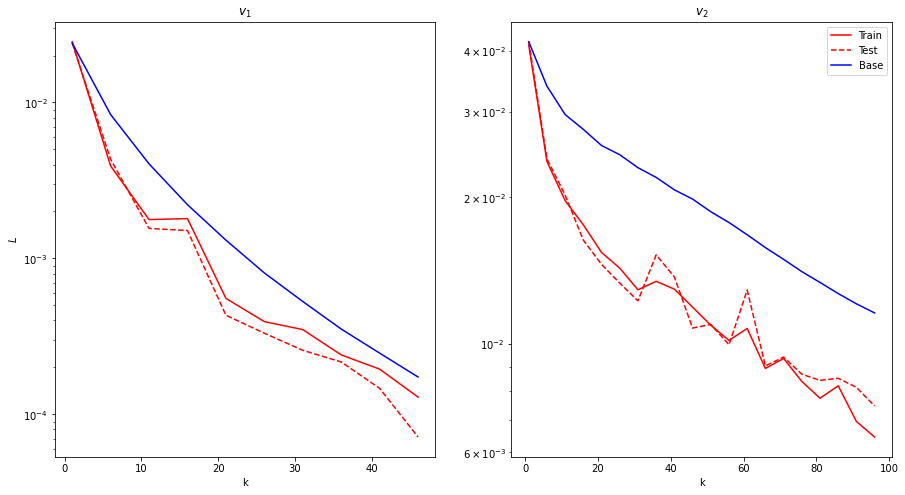

In [36]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
metrics = []
for k in torch.arange(1,50,5):
  metrics.append(power_train_loop(train_loader,test_loader,rank=0,k=k.long().item(),lr=1e-1))

metrics = torch.Tensor(metrics)
plt.semilogy(torch.arange(1,50,5),metrics[:,0],color='r',label='Train')
plt.semilogy(torch.arange(1,50,5),metrics[:,1],color='r',linestyle='--',label='Test')
plt.semilogy(torch.arange(1,50,5),metrics[:,2],label='Base')
plt.ylabel('$L$')
plt.xlabel('k')
plt.title("$v_{1}$")

plt.subplot(1,2,2)
metrics = []
for k in torch.arange(1,100,5):
  metrics.append(power_train_loop(train_loader,test_loader,1,k.long().item()))

metrics = torch.Tensor(metrics)
plt.semilogy(torch.arange(1,100,5),metrics[:,0],color='r',label='Train')
plt.semilogy(torch.arange(1,100,5),metrics[:,1],color='r',linestyle='--',label='Test')
plt.semilogy(torch.arange(1,100,5),metrics[:,2],label='Base')
plt.xlabel('k')
plt.title("$v_{2}$")
plt.legend();

The figure shows a) convergence to $v_{1}$ and b) convergence to the second-dominant eigenvector, $v_{2}$, by orthogonalizing out $v_{1}$ at each iteration. "Base" is the standard Power Iteration algorithm. When convergence is already (relatively) quick, our accelerated scheme offers only about $5-10$ iterations worth of speedup. This could potentially be improved with some hyperparameter tuning; $\eta{}$ is probably too large. However, if convergence is *very* slow (as is most often the case for $v_{2}$ or lower eigenvectors), then we can substantially decrease the number of iterations required to reach a particular approximation accuracy.

#### Accelerated GCNs

Let's now try something similar with GraphConv. The bulk of the model is identical to before; however, instead of simply passing the output of the final layer to a regression head, $\Theta{}^{out}$, we sum over each $x^{l}$ with coefficients $c_{l}$. 

$$ x^{out}_{i} = \Theta{}^{out}(\frac{\sum_{l=0}^{l_{max}}c_{l}\vec{x}_{i}^{l}}{||\sum_{l=0}^{l_{max}}c_{l}\vec{x}_{i}^{l}||_{2}})$$

Input to $\Theta{}^{R}$ is no longer the Rayleigh Quotient, but instead the magnitude of the vector projection of each $x^{l}$ onto $x^{l-1}$. Even though it no longer functions as an upper bound, we still find normalizing by the $\lambda_{umax}$ of $A$ to be beneficial.

$$ \vec{c} = \Theta{}^{R}([\frac{(\vec{x}^{0})^{T}\vec{x}^{1}}{\lambda_{umax}(\vec{x}^{0})^{T}\vec{x}^{0}},
\frac{(\vec{x}^{1})^{T}\vec{x}^{2}}{\lambda_{umax}(\vec{x}^{1})^{T}\vec{x}^{1}},...,\frac{(\vec{x}^{l_{max-1}})^{T}\vec{x}^{l_{max}}}{\lambda_{umax}(\vec{x}^{l_{max-1}})^{T}\vec{x}^{l_{max-1}})}]) $$

Given our results for Power Iterations, we are not expecting much improvement here over base GraphConv, if any at all. Accelerated GCNs may, however, prove useful later down the line when we wish to do something with $v_{2},v_{3},...,v_{n}$, so consider this a test run. 

In [41]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    _,vecs = torch.eig(adj.to_dense(),eigenvectors=True)

    G.y = y
    d[idx] = G
    
train,test = d[:200],d[200::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=25,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=25,shuffle=True)

In [43]:
class PolynomialGraphConv(torch.nn.Module):
    # in_channels and out_channels are self-explanatory. int_channels is the number of 
    # features in the intermediate layers. Depth controls the number of aggregations.
    def __init__(self,in_channels,int_channels,out_channels,depth,norm=True):
        super(PolynomialGraphConv,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.polynomial = torch.nn.Sequential(*[torch.nn.Linear(depth,2*depth),torch.nn.LeakyReLU(),
                                                torch.nn.Linear(2*depth,2*depth),torch.nn.LeakyReLU(),
                                                torch.nn.Linear(2*depth,depth+1)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        self.norm = norm
        
    def compute_R(self,X,nX,edge_index,batch):
        R = torch_scatter.scatter_sum(X*nX,batch,dim=0)/torch_scatter.scatter_sum(
                              X**2,batch,dim=0)
        Rmax = torch_scatter.scatter_max(torch_sparse.SparseTensor(row=edge_index[0],col=edge_index[1]).sum(1),batch,dim=0)[0]
        return (R/Rmax[:,None])
    
    def forward(self,X,edge_index,edge_weight,batch):
        # Project to int_channels
        X = self.start(X)
        
        Z = X[:,:,None]
        # Run through GraphConv layers
        for idx,m in enumerate(self.intermediate):
            nX = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            if self.norm: nX = nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch]
            nX = torch.nn.LeakyReLU()(nX)
        
            if idx==0: R = self.compute_R(X,nX,edge_index,batch)[:,:,None]
            else: R = torch.cat((R,self.compute_R(X,nX,edge_index,batch)[:,:,None]),dim=2)
            X = nX
            Z = torch.cat((Z,X[:,:,None]),dim=2)

        coefficients = self.polynomial(R)[batch]
        Z = torch.sum(coefficients * Z,dim=2)
        
        # Project to out_channels
        out = self.finish(X)
        return out

In [44]:
polynomial_results = []
for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    model = PolynomialGraphConv(1,16,1,k).cuda()
    
    polynomial_results.append(train_loop(model,train_loader,test_loader,300,lr=1e-1))
    torch.cuda.empty_cache()

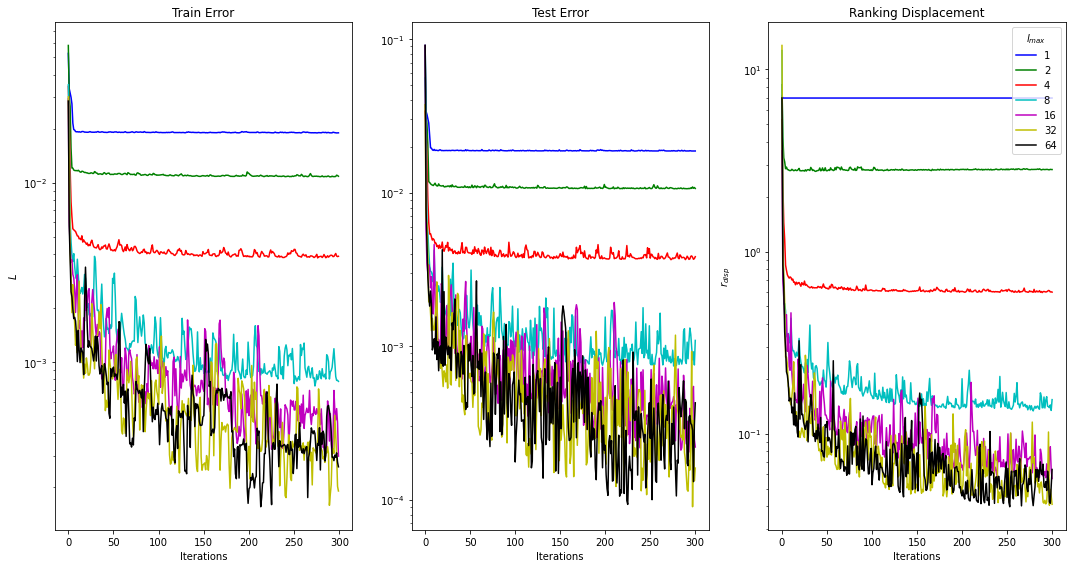

In [45]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(polynomial_results[i][0])

plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(polynomial_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(polynomial_results[idx][2],label=alpha)
plt.title('Ranking Displacement')
plt.ylabel('$r_{disp}$')
plt.xlabel('Iterations')
plt.legend(title='$l_{max}$')

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for $l_{max}=1,2,4,...,64$. The figure below shows the average values on the train and test loss over the last 10 epochs versus $l_{max}$. 

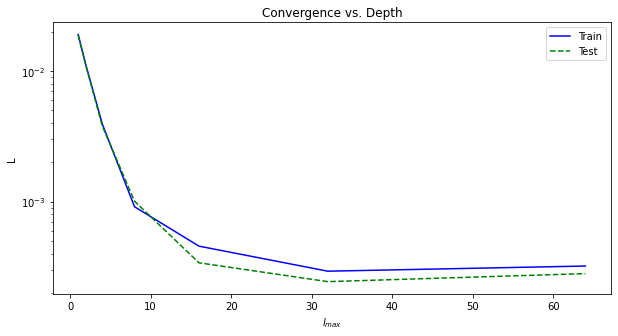

In [47]:
plt.figure(figsize=(10,5))
params = [1,2,4,8,16,32,64]
plt.semilogy(params,[np.mean(polynomial_results[i][0][-10::]) for i in range(7)],label='Train')
plt.semilogy(params,[np.mean(polynomial_results[i][1][-10::]) for i in range(7)],linestyle='--',label='Test')
plt.legend();
plt.xlabel('$l_{max}$')
plt.ylabel('L');
plt.title('Convergence vs. Depth');

Compared to the base model, our accelerated GraphConv shows no improvement in learning $d_{Katz}$, which, again, was mostly expected. The convergence is certainly less smooth, which manifests in the more prominent decay from $l_{max}=32$ to $l_{max}=64$. We likely need to retrain with either a smaller $\eta{}$ or a scheduler of some sort. Still, the fact that the model is not truly any worse bodes well for future experiments. 